In [50]:
from tqdm import tqdm
import os, os.path

imgs = []
path = "./leniwce_run2/masks/"

for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() != ".jpg":
        continue
    imgs.append(os.path.join(path,f))

imgs.sort()

In [8]:
import numpy as np
import cv2
from fastiecm import fastiecm
import matplotlib.pyplot as plt

In [5]:
def detect_night(im):
    in_min = np.percentile(im, 5) # Adjust percentile for better detection
    in_max = np.percentile(im, 95)

    if in_min == in_max:
        return True

    return False

In [9]:
def preprocess_image(image):
    image = np.array(image, dtype=float)/float(255)
    shape = image.shape
    height = int(shape[0] / 2)
    width = int(shape[1] / 2)
    image = cv2.resize(image, (width, height))

    return cv2.cvtColor(image.astype(np.float32), cv2.COLOR_BGR2RGB)

In [10]:
def contrast_stretch(im):
    in_min = np.percentile(im, 5)
    in_max = np.percentile(im, 95)

    out_min = 0.0
    out_max = 255.0

    out = im - in_min

    out *= ((out_min - out_max) / (in_min - in_max))
    out += in_min

    return out

In [11]:
def calc_ndvi(image):
    b, g, r = cv2.split(image)
    bottom = (r.astype(float) + b.astype(float))
    bottom[bottom==0] = 0.01
    ndvi = (b.astype(float) - r) / bottom
    return ndvi

In [30]:
!cp leniwce_run2/photos/photo_009.jpg test.jpg
!cp leniwce_run2/masks/photo_009.jpg test_mask.jpg

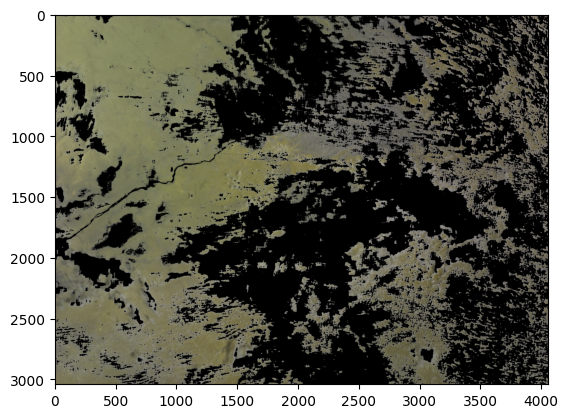

In [67]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

image = cv2.imread("test.jpg")
mask = cv2.imread("test_mask.jpg")
mask = np.sum(mask, axis=2) > 350
mask = np.uint8(mask)  

image = cv2.bitwise_and(image, image, mask=mask)

plt.imshow(image)
plt.show()

In [68]:
def ndvi_procedure(image):
    contrasted = contrast_stretch(image)
    ndvi = calc_ndvi(contrasted)
    ndvi_contrasted = contrast_stretch(ndvi)

    return ndvi_contrasted

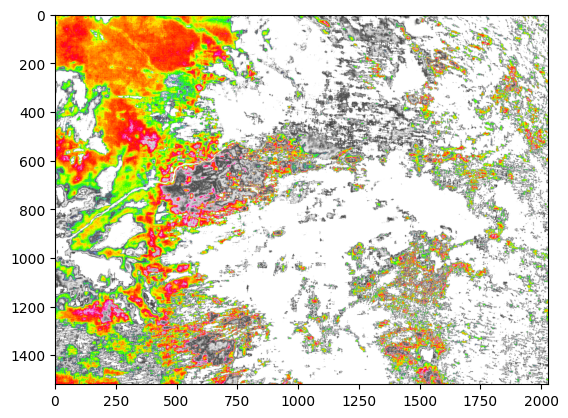

In [69]:
ndvi_contrasted = ndvi_procedure(image)

color_mapped_prep = ndvi_contrasted.astype(np.uint8)
color_mapped_image = cv2.applyColorMap(color_mapped_prep, fastiecm)

plt.imshow(preprocess_image(color_mapped_image))
plt.show()

In [71]:
for image_path in tqdm(imgs):
    image = cv2.imread(image_path.replace("masks", "photos"))    
    mask = cv2.imread(image_path)
    mask = np.sum(mask, axis=2) > 350
    mask = np.uint8(mask)  

    image = cv2.bitwise_and(image, image, mask=mask)

    if not detect_night(image):
        ndvi_contrasted = ndvi_procedure(image)

        color_mapped_prep = ndvi_contrasted.astype(np.uint8)
        color_mapped_image = cv2.applyColorMap(color_mapped_prep, fastiecm)

        cv2.imwrite(image_path.replace("masks", "ndvi"), ndvi_contrasted)
        cv2.imwrite(image_path.replace("masks", "ndvi_color"), color_mapped_image)

100%|██████████| 189/189 [03:08<00:00,  1.00it/s]
